In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK
from os import listdir
from os.path import isfile, join
import numpy as np
import tqdm
from matplotlib import pyplot as plt
import pickle
%matplotlib inline

REPEATS = 10
MAX_EVALS = 20

In [12]:
#Get the list of all available files
files = np.array([f for f in listdir('./XGBonGrid/') if isfile(join('./XGBonGrid/', f)) and f[-4:] == '.txt'])

In [13]:
#This is the space of XGB hyperparameters which we will tune
space = {
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 7))}

In [14]:
def objective(params):
    global file, times, qualities
    #Let's load the file with precomputed results
    f = np.loadtxt('./XGBonGrid/'+file,delimiter=', ')
    #The list of all possible hyperparameter configurations
    configurations = [[i,j] for i in range(3,11) for j in range(1,7)]
    #Don't forget to scale the quality to [0,1]
    if np.max(f[:,2]) != np.min(f[:,2]):
        f[:,2] = (f[:,2] - np.min(f[:,2]))/(np.max(f[:,2])-np.min(f[:,2]))
    #Get the normalized quality which corresponds to requested hyperparameters
    score = f[configurations.index([params['max_depth'],params['min_child_weight']]),2]
    #Get the precomputed time of quality evaluation
    if times != []:
        times.append(times[-1]+f[configurations.index([params['max_depth'],params['min_child_weight']]),3])
    else:
        times.append(f[configurations.index([params['max_depth'],params['min_child_weight']]),3])
    if qualities != []:
        if score > qualities[-1]:
            qualities.append(score)
        else:
            qualities.append(qualities[-1])
    else:
        qualities.append(score)
    return {'loss': -score, 'status': STATUS_OK }

In [15]:
Q = []
T = []
for _ in range(REPEATS):
    all_qualities = []
    all_times = []
    for file in tqdm.tqdm(files):
        times = []
        qualities = []
        best = fmin(objective,space=space,algo=tpe.suggest,max_evals=MAX_EVALS)
        all_qualities.append(qualities)
        all_times.append(times)
    Q.append(all_qualities)
    T.append(all_times)

100%|████████████████████████████████████████| 453/453 [00:52<00:00,  8.65it/s]


In [16]:
# pickle.dump(T,open("T.p","wb"))
# pickle.dump(Q,open("Q.p","wb"))

In [5]:
# Q = pickle.load(open("Q.p","rb"))
# T = pickle.load(open("times.p","rb"))

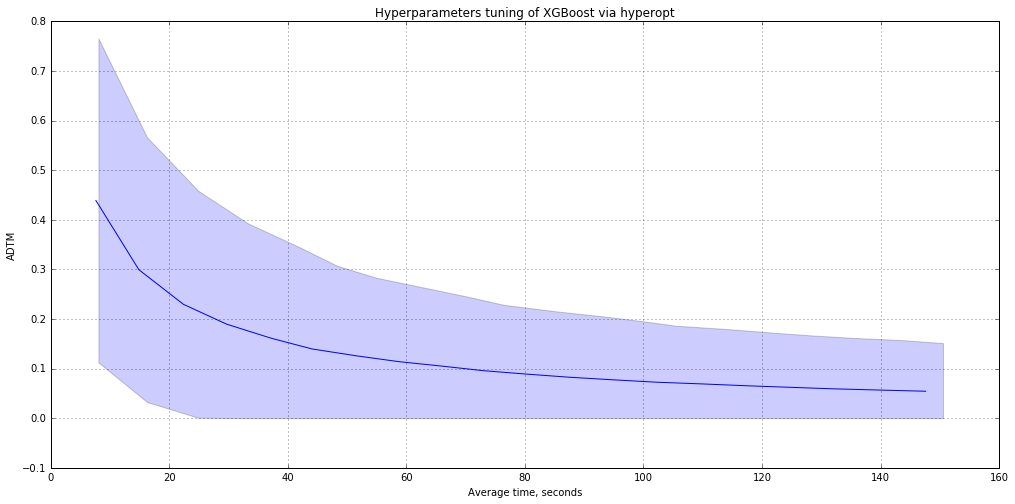

In [17]:
plt.figure(figsize=(17,8))
mean_results = 1-np.array([np.mean(np.array(Q)[:,:,i]) for i in range(MAX_EVALS)])
t = [np.mean(np.array(T)[:,:,i]) for i in range(MAX_EVALS)]
std = np.array([np.std(np.array(Q)[:,:,i]) for i in range(MAX_EVALS)])
plt.plot(t,mean_results)
plt.fill_between(np.mean(np.array(all_times),axis=0), np.maximum(mean_results-std,0), mean_results+std, alpha=0.2)
plt.grid()
plt.ylim(-0.1,0.8)
plt.xlabel("Average time, seconds")
plt.ylabel("ADTM")
# plt.legend(fontsize='large')
plt.title("Hyperparameters tuning of XGBoost via hyperopt")
# plt.savefig('XGBhyperopt.pdf')